In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/CS376"

/content/drive/MyDrive/CS376


In [ ]:
cd "datasets"

/content/drive/MyDrive/CS376/datasets


In [ ]:
!unzip val2014.zip

Archive:  val2014.zip
replace val2014/COCO_val2014_000000324670.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
 extracting: val2014/COCO_val2014_000000220025.jpg  


In [ ]:
!git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning

Cloning into 'a-PyTorch-Tutorial-to-Image-Captioning'...
remote: Enumerating objects: 272, done.
remote: Total 272 (delta 0), reused 0 (delta 0), pack-reused 272
Receiving objects: 100% (272/272), 12.89 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [ ]:
cd "/content/drive/MyDrive/CS376"

/content/drive/MyDrive/CS376


In [ ]:
cd "a-PyTorch-Tutorial-to-Image-Captioning"

/content/drive/MyDrive/CS376/a-PyTorch-Tutorial-to-Image-Captioning


In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 24.8 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.8 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!python create_input_files.py

In [ ]:
!python train.py

Epoch: [21][0/17702]	Batch Time 48.001 (48.001)	Data Load Time 45.601 (45.601)	Loss 2.8990 (2.8990)	Top-5 Accuracy 81.461 (81.461)
Epoch: [21][100/17702]	Batch Time 0.349 (3.391)	Data Load Time 0.000 (3.002)	Loss 3.3066 (2.9025)	Top-5 Accuracy 72.603 (79.901)
Epoch: [21][200/17702]	Batch Time 0.364 (1.964)	Data Load Time 0.000 (1.585)	Loss 3.0636 (2.9134)	Top-5 Accuracy 78.167 (79.761)
Epoch: [21][300/17702]	Batch Time 0.358 (1.455)	Data Load Time 0.000 (1.081)	Loss 2.9738 (2.9117)	Top-5 Accuracy 78.342 (79.841)
Epoch: [21][400/17702]	Batch Time 0.374 (1.194)	Data Load Time 0.000 (0.822)	Loss 2.9593 (2.9149)	Top-5 Accuracy 78.628 (79.814)
Epoch: [21][500/17702]	Batch Time 0.357 (1.038)	Data Load Time 0.000 (0.667)	Loss 3.0280 (2.9205)	Top-5 Accuracy 77.135 (79.742)
Epoch: [21][600/17702]	Batch Time 0.378 (0.929)	Data Load Time 0.000 (0.558)	Loss 3.1414 (2.9197)	Top-5 Accuracy 75.978 (79.723)
Epoch: [21][700/17702]	Batch Time 0.360 (0.850)	Data Load Time 0.000 (0.479)	Loss 2.9995 (2.920

In [ ]:
!python eval.py

EVALUATING AT BEAM SIZE 1: 100% 25000/25000 [14:53<00:00, 27.98it/s]

BLEU-4 score @ beam size of 1 is 0.2723.


In [ ]:
!python caption.py --img /content/drive/MyDrive/CS376/datasets/test2014/COCO_test2014_000000000001.jpg --model /content/drive/MyDrive/CS376/a-PyTorch-Tutorial-to-Image-Captioning/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar --word_map /content/drive/MyDrive/CS376/datasets/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json

caption.py:32: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(image_path)
caption.py:36: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  img = imresize(img, (256, 256))
<Figure size 640x480 with 13 Axes>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


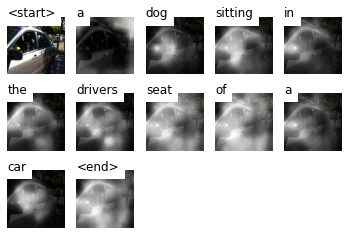

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = (top_k_words / vocab_size).long()  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


args_img = "/content/drive/MyDrive/CS376/datasets/test2014/COCO_test2014_000000000027.jpg"
args_model = "/content/drive/MyDrive/CS376/a-PyTorch-Tutorial-to-Image-Captioning/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar"
args_word_map = "/content/drive/MyDrive/CS376/datasets/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json"

# Load model
checkpoint = torch.load(args_model, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(args_word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, args_img, word_map, 5)
alphas = torch.FloatTensor(alphas)

# Visualize caption and attention of best sequence
visualize_att(args_img, seq, alphas, rev_word_map)
